In [10]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.stats import gaussian_kde

In [4]:
crime_gdf = gpd.read_file("./geojson/aichi-crime-2020.geojson")
print(len(crime_gdf))

45456


In [5]:
# 直交座標系に変換
crime_gdf = crime_gdf.to_crs(6675)

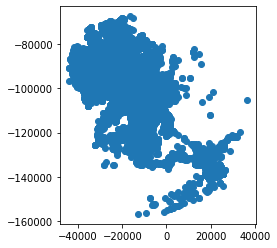

In [6]:
crime_gdf[crime_gdf["relevance"] > 0.8].plot()

In [7]:
n_sample = 100
sample_gdf = crime_gdf[crime_gdf["relevance"]>0.8].sample(n_sample)
display(sample_gdf)

,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
31442,crime-31443,窃盗,車上ねらい,安城,安城駅前,232122,愛知県,安城市,安城町社口堂,2018-08-02,21,駐車（輪）場,"日本, 愛知県安城市安城町社口堂",0.99,POINT (-6961.581 -116913.868)
28549,crime-28550,窃盗,部品ねらい,小牧,小牧,232190,愛知県,小牧市,常普請３丁目,2018-12-26,22,その他,"日本, 愛知県小牧市常普請3丁目",0.99,POINT (-22621.920 -79713.514)
21362,crime-21363,窃盗,自転車盗,昭和,阿由知,231070,愛知県,名古屋市昭和区,東畑町２丁目,2020/11/30,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市昭和区東畑町2丁目",0.99,POINT (-21435.226 -94224.439)
6379,crime-06380,窃盗,自転車盗,中村,笹島,231053,愛知県,名古屋市中村区,名駅南１丁目,2019/5/19,14,駐車（輪）場,"日本, 愛知県名古屋市中村区名駅南1丁目1番",0.99,POINT (-25042.471 -92380.934)
35015,crime-35016,窃盗,自転車盗,西,比良,231045,愛知県,名古屋市西区,比良２丁目,2018-03-15,20,道路上,"日本, 愛知県名古屋市西区比良2丁目",0.99,POINT (-24252.281 -85698.439)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136,crime-07137,窃盗,自転車盗,瑞穂,豊岡,231088,愛知県,名古屋市瑞穂区,瑞穂通６丁目,2019/11/6,16,その他,"日本, 愛知県名古屋市瑞穂区瑞穂通6丁目",0.99,POINT (-21052.283 -97223.775)
23324,crime-23325,窃盗,自転車盗,東,矢田,231029,愛知県,名古屋市東区,矢田２丁目,2020/3/26,14,その他,"日本, 愛知県名古屋市東区矢田2丁目13番",0.99,POINT (-20479.024 -89280.638)
2602,crime-02603,窃盗,車上ねらい,東海,富木島,232220,愛知県,東海市,富木島町向イ,2019/9/25,18,駐車（輪）場,"日本, 愛知県東海市富木島町向イ",0.99,POINT (-22932.055 -108650.877)
22953,crime-22954,窃盗,自転車盗,豊川,稲荷通,232076,愛知県,豊川市,駅前通３丁目,2020/6/16,6,その他,"日本, 愛知県豊川市駅前通3丁目",0.99,POINT (20231.059 -130879.032)


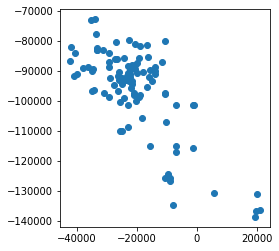

In [9]:
sample_gdf.plot()

In [31]:
coord_list= []
for g in sample_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])
print(coord_list)

[(-6961.580798453101, -116913.86831036846), (-22621.92032175059, -79713.51435239507), (-21435.2257379476, -94224.43906228949), (-25042.470789507006, -92380.93418933165), (-24252.280510552973, -85698.4390820055), (-8862.566018407293, -126565.66397647811), (-10647.853174018484, -125699.19589205844), (-26319.495605235967, -96772.78818428547), (-25884.291012136986, -92950.57021421693), (-28994.631302533217, -92284.3690731184), (-10118.292635041427, -107083.59712251186), (-18729.253421700745, -81531.65652552147), (-27317.04898737691, -85915.79552453998), (-25529.142750402323, -110101.48879907725), (-22927.705278939306, -88198.6924087233), (-15795.237189662972, -92143.31333085925), (-7010.2663599809985, -114906.21898929168), (-19799.895912691947, -87278.74098225284), (-10642.54379023055, -97603.30403289555), (-34752.76149674768, -89895.58853385539), (-770.2424483535169, -101190.60983897353), (-17732.109187340884, -90222.63050434394), (-29153.054282822264, -88684.0786030611), (-20559.62368176

In [50]:
kde = gaussian_kde(coord_list, bw_method=0.05)